Hunter Bennett | Glass Lab | Kupffer Strains Project | 4 June 2021

This is a re-vamp of the differential peak calling pipeline for comparisons within strains in a given condition (healthy, CCl4, NASH). This pipeline takes in ATAC-seq peaks annotated with H3K27Ac ChIP-seq data (or other histone modified data) from three strains (c57, balb, and aj) and compares each strain to the other pairwise. The main outputs of this file are:
1. A homer differential peak file containing each pairwise comparison.
2. Scatterplots of each pairwise comparison with significant peaks highlighted.
3. Heatmaps of differential peaks across all comparisons to highlight patterns.
4. Peak files for GREAT analysis of functional annotations associated with genomic regions.

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [3]:
controlDirectory = '/home/h1bennet/strains/data/ATAC/control_cohort2/'
lpsDirectory = '/home/h1bennet/strains/data/ATAC/Leptin_6hours/'
workingDirectory = '/home/h1bennet/strains/results/11_Strains_Leptin_6h_ATAC//'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


### Read in raw gene expression files

In [6]:
df, mat = read_annotated_peaks('./peakQuan/allRawTags.txt')

In [8]:
best_reps = ['/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/control_cohort2/c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C571_TDT_l20210213_TACTACGC_AAGGAGTA_S19_L001_trim30',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/control_cohort2/c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C572_TDT_l20210213_AGGCTCCG_CTAAGCCT_S20_L001_trim30',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/control_cohort2/c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C573_TDT_l20210213_GCAGCGTA_CGTCTAAT_S21_L001_trim30',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/control_cohort2/c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C574_TDT_l20210213_CTGCGCAT_TCTCTCCG_S22_L001_trim30',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/Leptin_6hours/c57bl6j_Male_Kupffer_ATAC_Leptin6hrFasted_20210512L1_TDT_s20210512_TCCTGAGC_GTAAGGAG.c57bl6j.bowtie2_shifted_from_C57BL6J.sam',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/Leptin_6hours/c57bl6j_Male_Kupffer_ATAC_Leptin6hrFasted_20210512L2_TDT_s20210512_GGACTCCT_ACTGCATA.c57bl6j.bowtie2_shifted_from_C57BL6J.sam',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/Leptin_6hours/c57bl6j_Male_Kupffer_ATAC_Leptin6hrFasted_20210512L3_TDT_s20210512_AAGAGGCA_CGTCTAAT.c57bl6j.bowtie2_shifted_from_C57BL6J.sam',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/control_cohort2/balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB1_TDT_l20210213_TCATGAGC_CTCTCTAT_S15_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/control_cohort2/balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB2_TDT_l20210213_CCTGAGAT_TATCCTCT_S16_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/control_cohort2/balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB3_TDT_l20210213_TAGCGAGT_GTAAGGAG_S17_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/control_cohort2/balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB4_TDT_l20210213_GTAGCTCC_ACTGCATA_S18_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/Leptin_6hours/balbcj_Male_Kupffer_ATAC_Leptin6hrFasted_20210512L2_TDT_s20210512_CGAGGCTG_CTAAGCCT.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/Leptin_6hours/balbcj_Male_Kupffer_ATAC_Leptin6hrFasted_20210512L3_TDT_s20210512_GTAGAGGA_TCTCTCCG.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/control_cohort2/aj_Male_Kupffer_ATAC_Chow_healthyoung_AJ1_TDT_l20210213_GTAGAGAG_CTATTAAG_S11_L001_trim30.aj.bowtie2_shifted_from_AJ.sam',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/control_cohort2/aj_Male_Kupffer_ATAC_Chow_healthyoung_AJ2_TDT_l20210213_CAGCCTCG_AAGGCTAT_S12_L001_trim30.aj.bowtie2_shifted_from_AJ.sam',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/control_cohort2/aj_Male_Kupffer_ATAC_Chow_healthyoung_AJ3_TDT_l20210213_TGCCTCTT_GAGCCTTA_S13_L001_trim30.aj.bowtie2_shifted_from_AJ.sam',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/control_cohort2/aj_Male_Kupffer_ATAC_Chow_healthyoung_AJ4_TDT_l20210213_TCCTCTAC_TTATGCGA_S14_L001_trim30.aj.bowtie2_shifted_from_AJ.sam',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/Leptin_6hours/aj_Male_Kupffer_ATAC_Leptin6hrFasted_20210510L5_TDT_s20210510_GCTCATGA_TCGACTAG.aj.bowtie2_shifted_from_AJ.sam',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/Leptin_6hours/aj_Male_Kupffer_ATAC_Leptin6hrFasted_20210510L6_TDT_s20210510_ATCTCAGG_TTCTAGCT.aj.bowtie2_shifted_from_AJ.sam',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/Leptin_6hours/aj_Male_Kupffer_ATAC_Leptin6hrFasted_20210512L1_TDT_s20210512_AGGCAGAA_TATCCTCT.aj.bowtie2_shifted_from_AJ.sam']

In [10]:
# import annotation file
df, mat = read_annotated_peaks('./peakQuan/allRawTags.txt')
# pull out selected samples
tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
df= df.loc[:, tst]

df.to_csv('./peakQuan/allRawTags_samples_filtered.txt', sep='\t')

In [11]:
groups = [[0,1,2,3],
         [4,5,6],
         [7,8,9,10],
         [11,12],
         [13,14,15,16],
         [17,18,19]]
thresh = 16

subset comparisons that we want to do

In [18]:
strains = ['c57bl6j', 'balbcj', 'aj']
df, mat = read_annotated_peaks(
    './peakQuan/allRawTags.txt')
df.index.rename('PeakID')
# drop bad qc samples
tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
df = df.loc[:, tst]
mat = mat.loc[:, mat.columns.str.contains('|'.join(best_reps))]

# use group based mat filter - have to set manually
print(mat.shape[0], 'total peaks')
print('filtering low tag count peaks')
peaks = []
for group in groups:
    peaks.extend(mat.loc[mat.iloc[:, group].mean(1) > thresh, :].index.tolist())
df = df.reindex(list(set(peaks)))
df = df.dropna(how='all')
mat = mat.reindex(list(set(peaks)))
mat = mat.dropna(how='all')
print(mat.shape[0], 'total peaks')

for strain in strains:
    print(strain)
    # pull out selected strain
    tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains(strain))
    # print(tst)
    tmp = df.loc[:, tst]
    print(tmp.columns)
    tmp.to_csv(
        './peakQuan/allRawTags_'+strain+'_samples_filtered_peaks_filtered.txt',
        sep='\t')

87899 total peaks
filtering low tag count peaks
84876 total peaks
c57bl6j
Index(['Chr', 'Start', 'End', 'Strand', 'Peak Score',
       'Focus Ratio/Region Size', 'Annotation', 'Detailed Annotation',
       'Distance to TSS', 'Nearest PromoterID', 'Entrez ID', 'Nearest Unigene',
       'Nearest Refseq', 'Nearest Ensembl', 'Gene Name', 'Gene Alias',
       'Gene Description', 'Gene Type',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/control_cohort2/c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C571_TDT_l20210213_TACTACGC_AAGGAGTA_S19_L001_trim30',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/control_cohort2/c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C572_TDT_l20210213_AGGCTCCG_CTAAGCCT_S20_L001_trim30',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/control_cohort2/c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C573_TDT_l20210213_GCAGCGTA_CGTCTAAT_S21_L001_trim30',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/control_cohort2/c57b

# Run Differential Peaks for All Samples

## C57

In [20]:
%%bash

source activate deseq_36
getDiffExpression.pl ./peakQuan/allRawTags_c57bl6j_samples_filtered_peaks_filtered.txt \
00_c57bl6j_control 00_c57bl6j_control 00_c57bl6j_control 00_c57bl6j_control \
01_c57bl6j_leptin6h 01_c57bl6j_leptin6h 01_c57bl6j_leptin6h \
-peaks > ./peakQuan/c57bl6j_diff_output.txt


	Treating input as file generated by annotatePeaks.pl (-peaks)

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats 00_c57bl6j_control vs. 01_c57bl6j_leptin6h:
		Total Genes: 84876
		Total Up-regulated in 01_c57bl6j_leptin6h vs. 00_c57bl6j_control: 1938 (2.283%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 01_c57bl6j_leptin6h vs. 00_c57bl6j_control: 3559 (4.193%) [log2fold<-1, FDR<0.05]



### BALBcJ

In [23]:
%%bash

source activate deseq_36
getDiffExpression.pl ./peakQuan/allRawTags_balbcj_samples_filtered_peaks_filtered.txt \
00_balbcj_control 00_balbcj_control 00_balbcj_control 00_balbcj_control \
01_balbcj_leptin6h 01_balbcj_leptin6h \
-peaks > ./peakQuan/balbcj_diff_output.txt

	Treating input as file generated by annotatePeaks.pl (-peaks)

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats 00_balbcj_control vs. 01_balbcj_leptin6h:
		Total Genes: 84876
		Total Up-regulated in 01_balbcj_leptin6h vs. 00_balbcj_control: 574 (0.676%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 01_balbcj_leptin6h vs. 00_balbcj_control: 2645 (3.116%) [log2fold<-1, FDR<0.05]



### AJ

In [22]:
%%bash

source activate deseq_36
getDiffExpression.pl ./peakQuan/allRawTags_aj_samples_filtered_peaks_filtered.txt \
00_aj_control 00_aj_control 00_aj_control 00_aj_control \
01_aj_leptin6h 01_aj_leptin6h 01_aj_leptin6h \
-peaks > ./peakQuan/aj_diff_output.txt

	Treating input as file generated by annotatePeaks.pl (-peaks)

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats 00_aj_control vs. 01_aj_leptin6h:
		Total Genes: 84876
		Total Up-regulated in 01_aj_leptin6h vs. 00_aj_control: 2018 (2.378%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 01_aj_leptin6h vs. 00_aj_control: 3928 (4.628%) [log2fold<-1, FDR<0.05]



# Scatter plot of differentially acetylated enhancers

In [24]:
log2fc = np.log2(2)
pval = 0.05

## C57BL6J

In [25]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './peakQuan/c57bl6j_diff_output.txt',
    './peakQuan/allRawTags.txt')

comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (89968, 38)
getDiffExpression selected transcripts (84876, 28)
annotatePeaks selected peaks (84876, 38)


dict_keys(['00_c57bl6j_control vs. 01_c57bl6j_leptin6h'])

In [27]:
groups = [[0,1,2,3],
         [4,5,6],
         [7,8,9,10],
         [11,12],
         [13,14,15,16],
         [17,18,19]]

In [28]:
comps = ['00_c57bl6j_control vs. 01_c57bl6j_leptin6h']

groups = [[[0,1,2,3],
         [4,5,6]]]

cols = []
for i in groups:
    for j in i:
        cols.extend(j)
cols = [cols]

colors = [['#31a354', '#006d2c']]

00_c57bl6j_control vs. 01_c57bl6j_leptin6h
N peaks downregulated 3559
N peaks upregulated 1938



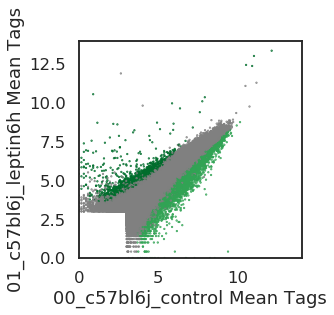

In [29]:
for key, col, group, color in zip(comps, cols, groups, colors):
    
    # make columns for plotting
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    de = de.reindex(de.index[(de.g0_mean >= 3) | (de.g1_mean >= 3)])

    dot_colors = []
    dot_sizes = []
    
    # create dot size list
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -log2fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > log2fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    
    # print DE peaks
    print(key)
    print('N peaks downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -log2fc)))
    print('N peaks upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > log2fc)))
    print('')
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=0.5, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
#     ax.text(0.5,15,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
#         fontsize=12,
#         c=color[1])
#     ax.text(15,0.5,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
#         fontsize=12,
#         c=color[0],
#         rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter_notext.png', bbox_inches='tight')
    # plt.close()

## BALBCJ

In [31]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './peakQuan/balbcj_diff_output.txt',
    './peakQuan/allRawTags.txt')

comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (89968, 38)
getDiffExpression selected transcripts (84876, 27)
annotatePeaks selected peaks (84876, 38)


dict_keys(['00_balbcj_control vs. 01_balbcj_leptin6h'])

In [32]:
comps = ['00_balbcj_control vs. 01_balbcj_leptin6h']

groups = [[[7,8,9,10],
         [11,12]]]

cols = []
for i in groups:
    for j in i:
        cols.extend(j)
cols = [cols]

colors = [['#3182bd', '#08519c']]

00_balbcj_control vs. 01_balbcj_leptin6h
N peaks downregulated 2645
N peaks upregulated 574



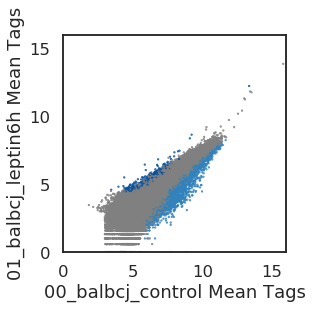

In [33]:
for key, col, group, color in zip(comps, cols, groups, colors):
    
    # make columns for plotting
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    de = de.reindex(de.index[(de.g0_mean >= 3) | (de.g1_mean >= 3)])
    dot_colors = []
    dot_sizes = []
    
    # create dot size list
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -log2fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > log2fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    
    # print DE peaks
    print(key)
    print('N peaks downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -log2fc)))
    print('N peaks upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > log2fc)))
    print('')
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=0.5, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
#     ax.text(0.5,15,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
#         fontsize=12,
#         c=color[1])
#     ax.text(15,0.5,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
#         fontsize=12,
#         c=color[0],
#         rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter_notext.png', bbox_inches='tight')
    # plt.close()

# Strains Control Comparison

In [35]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './peakQuan/aj_diff_output.txt',
    './peakQuan/allRawTags.txt')

comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (89968, 38)
getDiffExpression selected transcripts (84876, 28)
annotatePeaks selected peaks (84876, 38)


dict_keys(['00_aj_control vs. 01_aj_leptin6h'])

In [36]:
comps = ['00_aj_control vs. 01_aj_leptin6h']

groups = [[[13,14,15,16],
         [17,18,19]]]

cols = []
for i in groups:
    for j in i:
        cols.extend(j)
cols = [cols]

colors = [['#de2d26', '#a50f15']]

00_aj_control vs. 01_aj_leptin6h
N peaks downregulated 3927
N peaks upregulated 2018



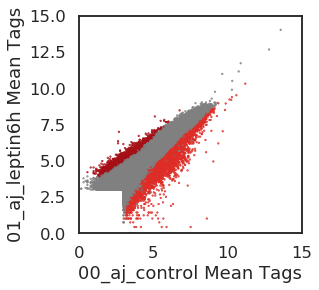

In [37]:
for key, col, group, color in zip(comps, cols, groups, colors):
    
    # make columns for plotting
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    de = de.reindex(de.index[(de.g0_mean >= 3) | (de.g1_mean >= 3)])
    
    dot_colors = []
    dot_sizes = []
    
    # create dot size list
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -log2fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > log2fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    
    # print DE peaks
    print(key)
    print('N peaks downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -log2fc)))
    print('N peaks upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > log2fc)))
    print('')
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=0.5, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
#     ax.text(0.5,15,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
#         fontsize=12,
#         c=color[1])
#     ax.text(15,0.5,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
#         fontsize=12,
#         c=color[0],
#         rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter_notext.png', bbox_inches='tight')
    # plt.close()

## Extract all peaks that have significant differences in ATAC tags

Iterate through the three DESeq2 outputs and select differential peaks, store in the peak dict for processing.
For the LPS comparison "up" is up in C57 compared to Balb

In [38]:
from matplotlib_venn import venn2

In [39]:
if not os.path.isdir('./peak_files/'):
    os.mkdir('./peak_files/')

In [42]:
convert_dict = {'Start': int,
                'End': int}

# set p value and log2fcs
padj = 0.05
log2fc = np.log2(2)

peak_dict = {}

for i in glob.glob('./peakQuan/*diff_output.txt'):
    diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
        i,
        './peakQuan/allNormTags.txt')
    
    # extract comparison name
    comp_name = i.split('/')[-1].split('_')[0]
    
    # extract distal peaks only
    diff_peak_distal = diff_peak.loc[np.abs(diff_peak.loc[:, 'Distance to TSS']) >= 3000, :]
    
    # log2fc is in position -3, adj p value is in position -1
    # positive peaks are up in NASH, negative peaks are down in NASH
    act = diff_peak.loc[(diff_peak.iloc[:, -3] >= log2fc) & (diff_peak.iloc[:, -1] < padj), :].index.tolist()
    rep = diff_peak.loc[(diff_peak.iloc[:, -3] <= -log2fc) & (diff_peak.iloc[:, -1] < padj), :].index.tolist()
    
    # activated peaks stored in the [0] position.
    peak_dict[i.split('/')[-1].split('_')[0].replace('./','')] = [act, rep]
    
    # save to list
    print(comp_name)
    print('n activated peaks:',diff_peak.reindex(act).dropna(how='all').shape[0])
    diff_peak.reindex(act).dropna(how='all').iloc[:, :4].astype(convert_dict).to_csv(
    './peak_files/%s_act_log2fc_%.1f_pval_%.2f.txt' % (comp_name, log2fc, pval),
    sep='\t')
    
    print('n distal activated peaks:',diff_peak_distal.reindex(act).dropna(how='all').shape[0])
    diff_peak_distal.reindex(act).dropna(how='all').iloc[:, :4].astype(convert_dict).to_csv(
    './peak_files/%s_distal_act_log2fc_%.1f_pval_%.2f.txt' % (comp_name, log2fc, pval),
    sep='\t')
    
    print('n repressed peaks:',diff_peak.reindex(rep).dropna(how='all').shape[0])
    diff_peak.reindex(act).dropna(how='all').iloc[:, :4].astype(convert_dict).to_csv(
    './peak_files/%s_rep_log2fc_%.1f_pval_%.2f.txt' % (comp_name, log2fc, pval),
    sep='\t')
    
    print('n distal repressed peaks:',diff_peak_distal.reindex(rep).dropna(how='all').shape[0])
    diff_peak_distal.reindex(act).dropna(how='all').iloc[:, :4].astype(convert_dict).to_csv(
    './peak_files/%s_distal_rep_log2fc_%.1f_pval_%.2f.txt' % (comp_name, log2fc, pval),
    sep='\t')

annotatePeaks all peaks (89968, 38)
getDiffExpression selected transcripts (84876, 28)
annotatePeaks selected peaks (84876, 38)
c57bl6j
n activated peaks: 1938
n distal activated peaks: 1646
n repressed peaks: 3559
n distal repressed peaks: 1056
annotatePeaks all peaks (89968, 38)
getDiffExpression selected transcripts (84876, 28)
annotatePeaks selected peaks (84876, 38)
aj
n activated peaks: 2018
n distal activated peaks: 1612
n repressed peaks: 3928
n distal repressed peaks: 1253
annotatePeaks all peaks (89968, 38)
getDiffExpression selected transcripts (84876, 27)
annotatePeaks selected peaks (84876, 38)
balbcj
n activated peaks: 574
n distal activated peaks: 427
n repressed peaks: 2645
n distal repressed peaks: 627


# Venn diagram for activated peaks


In [43]:
from matplotlib_venn import venn3

In [44]:
peak_dict.keys()

dict_keys(['c57bl6j', 'aj', 'balbcj'])

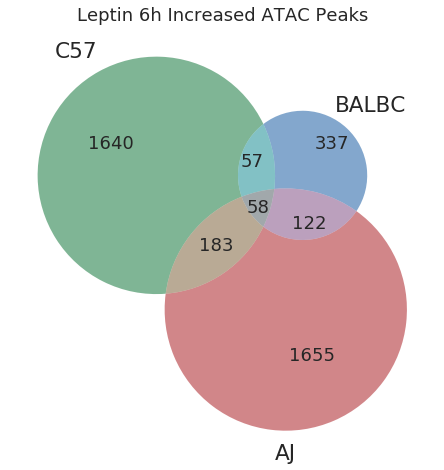

In [45]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn3(subsets=[set(peak_dict['c57bl6j'][0]),
               set(peak_dict['balbcj'][0]),
               set(peak_dict['aj'][0])],
     ax=ax,
     set_colors=('#006d2c', '#08519c', '#a50f15'),
     set_labels=('C57', 'BALBC', 'AJ'),
     alpha=0.5)
ax.set_title('Leptin 6h Increased ATAC Peaks');

plt.savefig('./figures/venn3_activated_peaks.png', bbox_inches='tight')

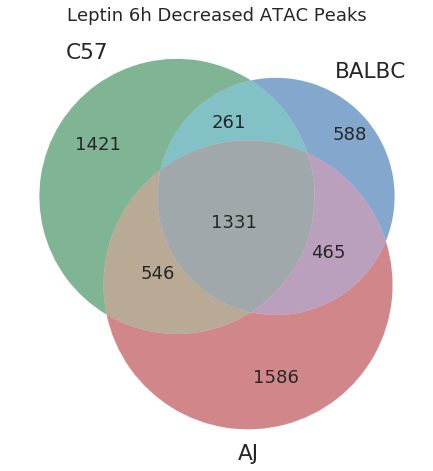

In [46]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn3(subsets=[set(peak_dict['c57bl6j'][1]),
               set(peak_dict['balbcj'][1]),
               set(peak_dict['aj'][1])],
     ax=ax,
     set_colors=('#006d2c', '#08519c', '#a50f15'),
     set_labels=('C57', 'BALBC', 'AJ'),
     alpha=0.5)
ax.set_title('Leptin 6h Decreased ATAC Peaks');

plt.savefig('./figures/venn3_repressed_peaks.png', bbox_inches='tight')

# Check peak quality

In [54]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './peakQuan/c57bl6j_diff_output.txt',
    './peakQuan/allRawTags.txt')

annotatePeaks all peaks (89968, 38)
getDiffExpression selected transcripts (84876, 28)
annotatePeaks selected peaks (84876, 38)


In [55]:
# make location column for peak dict (for examining on browser)
diff_peak['location'] = diff_peak.Chr + ':' + diff_peak.Start.map(str) + '-' + diff_peak.End.map(str)

In [57]:
diff_peak_filt = diff_peak.loc[diff_peak['00_c57bl6j_control vs. 01_c57bl6j_leptin6h adj. p-value'] < 0.05, :]

In [61]:
diff_peak_filt.sort_values('00_c57bl6j_control vs. 01_c57bl6j_leptin6h Log2 Fold Change', ascending=False).head(50)

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,...,/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/control_cohort2/c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C572_TDT_l20210213_AGGCTCCG_CTAAGCCT_S20_L001_trim30,/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/control_cohort2/c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C573_TDT_l20210213_GCAGCGTA_CGTCTAAT_S21_L001_trim30,/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/control_cohort2/c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C574_TDT_l20210213_CTGCGCAT_TCTCTCCG_S22_L001_trim30,/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/Leptin_6hours/c57bl6j_Male_Kupffer_ATAC_Leptin6hrFasted_20210512L1_TDT_s20210512_TCCTGAGC_GTAAGGAG.c57bl6j.bowtie2_shifted_from_C57BL6J.sam,/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/Leptin_6hours/c57bl6j_Male_Kupffer_ATAC_Leptin6hrFasted_20210512L2_TDT_s20210512_GGACTCCT_ACTGCATA.c57bl6j.bowtie2_shifted_from_C57BL6J.sam,/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/Leptin_6hours/c57bl6j_Male_Kupffer_ATAC_Leptin6hrFasted_20210512L3_TDT_s20210512_AAGAGGCA_CGTCTAAT.c57bl6j.bowtie2_shifted_from_C57BL6J.sam,00_c57bl6j_control vs. 01_c57bl6j_leptin6h Log2 Fold Change,00_c57bl6j_control vs. 01_c57bl6j_leptin6h p-value,00_c57bl6j_control vs. 01_c57bl6j_leptin6h adj. p-value,location
PeakID,,,,,,,,,,,,,,,,,,,,,
Merged-chr11-3174419-5,chr11,3174335,3174535,+,1000.000000,./peakIDR//c57_kupffer_leptin_2hours_atac.idr|...,"intron (NM_030207, intron 6 of 32)",B4A|SINE|B4,19028.0,NM_030207,...,4.096986,4.053745,4.010191,10.309169,10.008609,10.370514,10.836627,4.943537e-49,1.235423e-44,chr11:3174335-3174535
Merged-chr11-3151461-5,chr11,3151352,3151552,+,938.500000,./peakIDR//c57_kupffer_leptin_2hours_atac.idr|...,"intron (NM_030207, intron 14 of 32)",B1F|SINE|Alu,27431.0,NR_003517,...,3.116099,3.025476,3.038371,5.483911,5.424886,5.586810,8.881406,1.136445e-16,7.473822e-14,chr11:3151352-3151552
Merged-chr11-3157642-5,chr11,3157549,3157749,+,1000.000000,./peakIDR//c57_kupffer_leptin_2hours_atac.idr|...,"intron (NM_030207, intron 11 of 32)","intron (NM_030207, intron 11 of 32)",33628.0,NR_003517,...,3.751620,3.674496,3.930162,8.520896,8.048221,8.371763,8.679391,3.344307e-38,2.785882e-34,chr11:3157549-3157749
Merged-chr11-3144913-5,chr11,3144807,3145007,+,1000.000000,./peakIDR//c57_kupffer_leptin_2hours_atac.idr|...,"exon (NM_030207, exon 17 of 33)","exon (NM_030207, exon 17 of 33)",20886.0,NR_003517,...,3.399660,3.367105,3.293830,6.746161,6.880411,6.320673,8.524511,9.461531e-19,9.457999e-16,chr11:3144807-3145007
Merged-chr11-3128419-4,chr11,3128338,3128538,+,943.666687,./peakIDR//c57_kupffer_leptin_2hours_atac.idr|...,"intron (NR_003517, intron 3 of 6)","intron (NR_003517, intron 3 of 6)",4417.0,NR_003517,...,2.952583,2.878070,2.888634,4.777889,5.251167,4.750976,8.427889,1.302768e-14,5.337218e-12,chr11:3128338-3128538
Merged-chr11-3177335-7,chr11,3177170,3177370,+,1000.000000,./peakIDR//c57_kupffer_leptin_2hours_atac.idr|...,"intron (NM_030207, intron 6 of 32)","intron (NM_030207, intron 6 of 32)",16193.0,NM_030207,...,3.150588,3.057227,3.162911,5.322672,5.681173,5.738943,8.242875,3.892848e-15,1.882933e-12,chr11:3177170-3177370
Merged-chr11-3171440-5,chr11,3171352,3171552,+,973.133362,./peakIDR//c57_kupffer_leptin_2hours_atac.idr|...,"intron (NM_030207, intron 6 of 32)",B1_Mur1|SINE|Alu,22011.0,NM_030207,...,3.107450,3.019479,3.123909,5.210207,5.549423,5.450065,8.085602,1.545008e-14,6.227544e-12,chr11:3171352-3171552
Merged-chr11-3155943-5,chr11,3155834,3156034,+,940.533325,./peakIDR//c57_kupffer_leptin_2hours_atac.idr|...,"intron (NM_030207, intron 12 of 32)","intron (NM_030207, intron 12 of 32)",31913.0,NR_003517,...,2.801682,2.738717,2.747614,4.335540,4.937865,4.181514,8.081772,5.253351e-13,1.383339e-10,chr11:3155834-3156034
Merged-chr11-3159760-7,chr11,3159622,3159822,+,1000.000000,./peakIDR//c57_kupffer_leptin_2hours_atac.idr|...,"intron (NM_030207, intro